# Présentation des résultats

Chargement des Packages nécessaires

In [47]:
using CSV
using DataFrames
using DataFramesMeta
using Dates
using StatsPlots
using Statistics
using Temporal
using GLM
using TimeSeries: TimeArray 
using StatsBase
using Forecast
using LinearAlgebra

Données

In [48]:

# Fonction pour lire et filtrer les données
function read_and_filter_data(filepath, date_column::Symbol, value_column::Symbol, header_row::Int, skip_rows::Int)
    df = CSV.read(filepath, DataFrame, header = header_row, skipto = skip_rows, comment = "#", dateformat = "yyyymmdd", types = Dict(date_column => Date), normalizenames = true)
    df_filtered = filter(row -> year(row[date_column]) >= 1955 && year(row[date_column]) <= 2005, df)
    return df_filtered
end

# Lire tous les fichiers dans un dossier et agréger les données
function aggregate_data_from_folder(folder_path::String, date_column::Symbol, value_column::Symbol, header_row::Int, skip_rows::Int)
    files = readdir(folder_path)
    all_data = DataFrame()
    
    for file in files
        filepath = joinpath(folder_path, file)
        df = read_and_filter_data(filepath, date_column, value_column, header_row, skip_rows)
        append!(all_data, df)
    end
    
    # Supprimer les valeurs manquantes
    all_data = filter(row -> row[value_column] != 9, all_data)
    
    # Calculer la moyenne et l'écart type pour chaque date
    
    if value_column == :mm
        aggregated_data = @chain all_data begin
            @transform(:YEAR = year.(all_data[!, date_column])) # Ajouter une colonne pour l'année
            @by(date_column, :DAILY_MEAN = mean(:mm), :DAILY_STD = std(:mm)) # Grouper par date et calculer moyenne / écart type
        end
    else
        aggregated_data = @chain all_data begin
            @subset(:Q_RR .!= 9) # Supprimer les valeurs manquantes 
            @transform(:YEAR = year.(:DATE)) # Ajouter une colonne pour l'année
            @by(date_column, :DAILY_MEAN = mean(:RR), :DAILY_STD = std(:RR)) # Grouper par date et calculer moyenne / écart type
        end
    end

    return aggregated_data
end

# Chemins des dossiers
data_station_folder = "data_station_extract_script/data_rr"
data_drias_folder = "data_drias/Mod1_pluie"
data_mod2_folder = "data_drias/Mod2_pluie"

# Agréger les données des dossiers
data_station_aggregated = aggregate_data_from_folder(data_station_folder, :DATE, :RR, 20, 21)
data_drias_aggregated = aggregate_data_from_folder(data_drias_folder, :Date, :mm, 48, 49)
data_mod2_aggregated = aggregate_data_from_folder(data_mod2_folder, :Date, :mm, 47, 48)

# Conversion factor to °C for data_station
factor = 0.1
data_station_aggregated[!, :DAILY_MEAN] .= data_station_aggregated[!, :DAILY_MEAN] * factor
data_station_aggregated[!, :DAILY_STD] .= data_station_aggregated[!, :DAILY_STD] * factor

# Trier les données par date
sort!(data_station_aggregated, :DATE)
sort!(data_drias_aggregated, :Date)
sort!(data_mod2_aggregated, :Date)

df_daily = data_station_aggregated  
df_daily_drias = data_drias_aggregated
df_daily_mod2 = data_mod2_aggregated

# Convertir les données en séries temporelles
my_ts = TimeArray(data_station_aggregated[!, :DATE], data_station_aggregated[!, :DAILY_MEAN])
my_ts_drias = TimeArray(data_drias_aggregated[!, :Date], data_drias_aggregated[!, :DAILY_MEAN])
my_ts_mod2 = TimeArray(data_mod2_aggregated[!, :Date], data_mod2_aggregated[!, :DAILY_MEAN])

# Extraire les valeurs numériques de la série temporelle
data_values = values(my_ts)
data_values_drias = values(my_ts_drias)
data_values_mod2 = values(my_ts_mod2)


18628-element Vector{Float64}:
 0.3782
 2.5131333333333337
 1.9856666666666667
 0.7287333333333333
 0.454
 1.4132
 1.4959333333333333
 3.0634666666666672
 0.5024666666666666
 1.0291333333333332
 ⋮
 0.5379333333333334
 0.914
 1.4147333333333334
 6.8806
 2.437466666666667
 0.7500666666666667
 0.1192
 0.058866666666666664
 0.1032

## Premières Analyses

### Autocorrélogrammes

AUTOCORRÉLOGRAMME PARTIEL


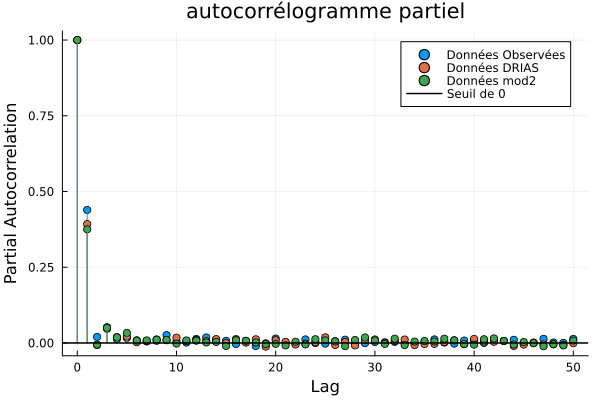

In [19]:
# Calculer l'autocorrélogramme partiel avec un nombre maximal de décalages spécifié
maxlag = 50 # Définir le nombre maximal de décalages
lags = collect(0:maxlag) # Créer une plage de décalages
pacf_values = StatsBase.pacf(data_values, lags)
pacf_values_drias = StatsBase.pacf(data_values_drias, lags)
pacf_values_mod2 = StatsBase.pacf(data_values_mod2, lags)

plot(0:maxlag, pacf_values, label = "Données Observées", xlabel="Lag", ylabel="Partial Autocorrelation", title="autocorrélogramme partiel", markershape=:circle, line=:stem)
plot!(0:maxlag, pacf_values_drias, label = "Données DRIAS", markershape=:circle, line=:stem)
plot!(0:maxlag, pacf_values_mod2, label = "Données mod2", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5, label = "Seuil de 0")

AUTOCORRÉLOGRAMME EMPIRIQUE

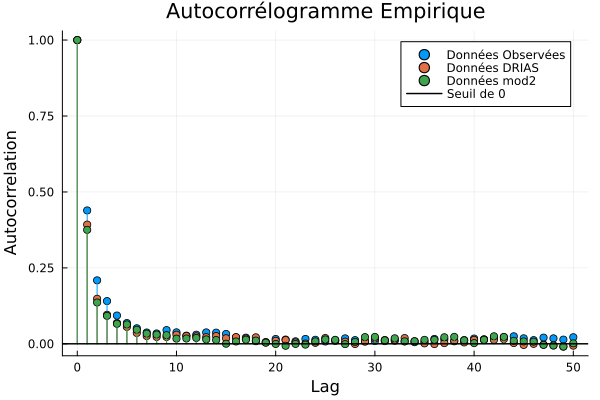

In [20]:
autocor_values = autocor(data_values, lags)
autocor_values_drias = autocor(data_values_drias, lags)
autocor_values_mod2 = autocor(data_values_mod2, lags)

# Tracer l'autocorrélogramme empirique avec les points reliés à l'axe des abscisses et une droite d'équation nulle
plot(0:maxlag, autocor_values, label = "Données Observées", xlabel="Lag", ylabel="Autocorrelation", title="Autocorrélogramme Empirique", markershape=:circle, line=:stem)
plot!(0:maxlag, autocor_values_drias, label = "Données DRIAS", markershape=:circle, line=:stem)
plot!(0:maxlag, autocor_values_mod2, label = "Données mod2", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5, label = "Seuil de 0")

### Séries temporelles et tendances

Tracé des deux avec moyennes mobiles classiques

In [65]:
function moyenne_mobile(data::Vector{T}, window_size::Int) where T
    n = length(data)
    trend = similar(data, T)
    for i in 1:n
        start_idx = max(1, i - window_size ÷ 2)
        end_idx = min(n, i + window_size ÷ 2)
        trend[i] = mean(@view(data[start_idx:end_idx]))
    end
    return trend
end

# Calculer la tendance par moyenne mobile avec une fenêtre de taille 730 (deux ans)
trend_values = moyenne_mobile(df_daily.DAILY_MEAN, 731)
trend_values_drias = moyenne_mobile(df_daily_drias.DAILY_MEAN, 731)
trend_values_mod2 = moyenne_mobile(df_daily_mod2.DAILY_MEAN, 731)

# Convertir les données en une série temporelle
datats = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)
datats_drias = TimeArray(df_daily_drias.Date, df_daily_drias.DAILY_MEAN)
datats_mod2 = TimeArray(df_daily_mod2.Date, df_daily_mod2.DAILY_MEAN)

# Tracer la série temporelle avec la tendance
plot(datats,  alpha=:0.5,label="Série temporelle observée", xlabel="Date", ylabel="Précipitations")
plot!(datats_drias, color=:darkorange,  palette =:tab10, alpha=:0.5, label="Série temporelle ALADIN63", xlabel="Date", ylabel="Précipitations")
plot!(datats_mod2,  color=:green, palette =:tab10, alpha=:0.4, label="Série temporelle RACMO22E", xlabel="Date", ylabel="Précipitations")
#plot!(df_daily.DATE, alpha=:0.75, trend_values, label="Tendance observée", linewidth=2, xlabel="Date", ylabel="Température (°C)")
#plot!(df_daily_drias.Date,  palette =:tab10, alpha=:0.75, trend_values_drias, label="Tendance ALADIN63", linewidth=2)
#plot!(df_daily_mod2.Date, palette =:tab10, alpha=:0.75, trend_values_mod2, label="Saisonnalité RACMO22E", linewidth=2)
savefig("Serie_pluies.pdf")


"/Users/mario/Changement_climatique/data/Serie_pluies.pdf"

Tracé des deux avec moyennes mobiles gaussien


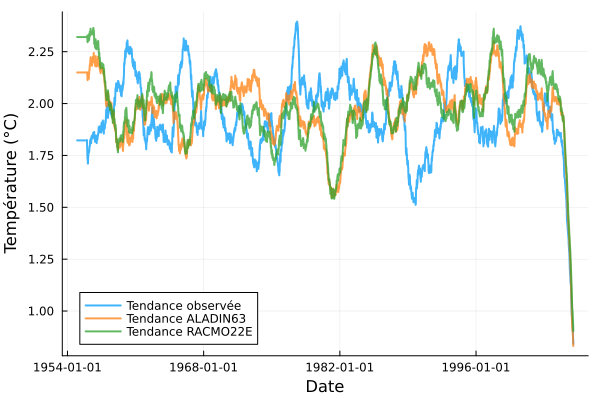

In [22]:

function moyenne_gauss(data::Vector{T}, window_size::Int) where T
    n = length(data)
    trend = similar(data, T)
    for i in 1:n
        weights = exp.(-(collect(1:window_size) .- (window_size ÷ 2)).^2 / (2 * (window_size / 2)^2))
        weights /= sum(weights)  # Normalisation des poids pour que leur somme soit égale à 1
        start_idx = max(1, i - window_size ÷ 2)
        end_idx = min(n, start_idx + window_size - 1)  # Ajustement de la fin de la tranche de données
        data_slice = @view(data[start_idx:end_idx])
        trend[i] = sum(data_slice .* weights[1:length(data_slice)])
    end
    return trend
end

# Calculer la Saisonnalité par moyenne mobile avec une fenêtre de taille 731 (deux ans)
trend_gauss = moyenne_gauss(df_daily.DAILY_MEAN, 731)
trend_gauss_drias = moyenne_gauss(df_daily_drias.DAILY_MEAN, 731)
trend_gauss_mod2 = moyenne_gauss(df_daily_mod2.DAILY_MEAN, 731)

# Tracer la série temporelle avec la tendance

plot(df_daily.DATE, alpha=:0.75,trend_gauss, label="Tendance observée", linewidth=2, xlabel="Date", ylabel="Température (°C)")
plot!(df_daily_drias.Date, palette =:tab10,alpha=:0.75, trend_gauss_drias, label="Tendance ALADIN63 ", linewidth=2)
plot!(df_daily_mod2.Date, alpha=:0.75, trend_gauss_mod2, label="Tendance RACMO22E", linewidth=2)
#savefig("Tendances_gaussien.pdf")


Décomposition de la série avec le package Forecast

In [50]:
stl_df = stl(df_daily,365; robust=true, spm=true)
stl_df_drias = stl(df_daily_drias,365; robust=true, spm=true)
stl_df_mod2 = stl(df_daily_mod2,365; robust=true, spm=true)
stl_df.decomposition
stl_df_drias.decomposition
stl_df_mod2.decomposition

┌ Info: Corvengence achieved (< 0.01); Stopping computation...
└ @ Forecast /Users/mario/.julia/packages/Forecast/Pu4g0/src/stl.jl:165
┌ Info: Corvengence achieved (< 0.01); Stopping computation...
└ @ Forecast /Users/mario/.julia/packages/Forecast/Pu4g0/src/stl.jl:165
┌ Info: Corvengence achieved (< 0.01); Stopping computation...
└ @ Forecast /Users/mario/.julia/packages/Forecast/Pu4g0/src/stl.jl:165


18628×4 DataFrame
   Row │ Timestamp   Seasonal  Trend    Remainder  
       │ Date        Float64   Float64  Float64    
───────┼───────────────────────────────────────────
     1 │ 1955-01-01  0.541984  1.84832  -2.01211
     2 │ 1955-01-02  0.520056  1.85089   0.142191
     3 │ 1955-01-03  0.501572  1.85345  -0.369353
     4 │ 1955-01-04  0.486131  1.85601  -1.6134
     5 │ 1955-01-05  0.473279  1.85856  -1.87784
     6 │ 1955-01-06  0.46252   1.86111  -0.910433
     7 │ 1955-01-07  0.453372  1.86366  -0.821101
     8 │ 1955-01-08  0.445406  1.86621   0.751851
   ⋮   │     ⋮          ⋮         ⋮         ⋮
 18622 │ 2005-12-25  0.48518   1.81934  -0.889791
 18623 │ 2005-12-26  0.511265  1.8191    4.55024
 18624 │ 2005-12-27  0.538407  1.81885   0.0802063
 18625 │ 2005-12-28  0.566487  1.8186   -1.63502
 18626 │ 2005-12-29  0.595195  1.81835  -2.29435
 18627 │ 2005-12-30  0.624125  1.8181   -2.38336
 18628 │ 2005-12-31  0.652867  1.81785  -2.36751
                                 18613 rows omitted

Tracé des deux avec moyennes mobiles du package Forecast


In [60]:
#plot(datats, alpha=:0.5, main = "Tendances", label="Série temporelle observée", xlabel="Date", ylabel="Température (°C)", legend=:topright)
#plot!(datats_drias,palette =:tab10,alpha=:0.5, label="Série temporelle ALADIN63", legend=:topright)
#plot!(datats_mod2,palette =:tab10,alpha=:0.5, label="Série temporelle RACMO22E", legend=:topright)
@df stl_df.decomposition plot(:Timestamp, :Trend, label="Tendance Observee",palette =:tab10, linewidth=2, xlabel="Date", ylabel="Précipitations (mm)")
@df stl_df_drias.decomposition plot!(:Timestamp, :Trend, label="Tendance ALADIN63",palette =:tab10, linewidth=2)
@df stl_df_mod2.decomposition plot!(:Timestamp, :Trend, label="Tendance RACMO22E",palette =:tab10, linewidth=2)
savefig("Tendances_Precipitations_Forecast.pdf")

"/Users/mario/Changement_climatique/data/Tendances_Precipitations_Forecast.pdf"

Comparaison des différentes méthodes des tendances

In [25]:
@df stl_df.decomposition plot(:Timestamp, :Trend,  main = "Tendances", label="Tendance (Forecast)",linewidth = 2)
@df stl_df_drias.decomposition plot!(:Timestamp, :Trend, label="Tendance ALADIN63 (Forecast)",linewidth = 2)
@df stl_df_mod2.decomposition plot!(:Timestamp, :Trend, label="Tendance RACMO22E (Forecast)",linewidth = 2)

#plot!(df_daily_drias.Date, color=:darkblue,trend_gauss_drias, label="Tendance DRIAS gaussien", linewidth=2)
#plot!(df_daily.DATE, color=:blue, trend_gauss, label="Tendance (Moyenne gaussien)", linewidth=2)

plot!(df_daily.DATE,color=:blue,  palette =:tab10, alpha=0.5,trend_values, label="Tendance (Moyenne mobile)", xlabel="Date", ylabel="Température (°C)")
plot!(df_daily_drias.Date, color=:darkorange,palette =:tab10, alpha=0.5, trend_values_drias, label="Tendance ALADIN63")
plot!(df_daily_mod2.Date,color=:green, palette =:tab10, alpha=0.5, trend_values_mod2, label="Tendance RACMO22E")
savefig("Tendances_Forecast_Moyenne-Mobile.pdf")

"/Users/mario/Changement_climatique/data/Tendances_Forecast_Moyenne-Mobile.pdf"

### SAISONNALITÉ

Calcul à la main d'une saisonnalité

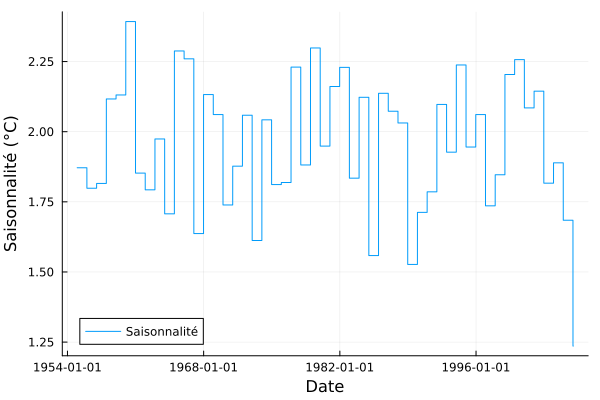

In [57]:

function saisonnalite(data::Vector{T}, period::Int) where T
    n = length(data)
    seasonal = similar(data, T) # Vecteur de la même taille et du meme type que data 
    seasonal_count = Int(ceil(n / period))
    
    seasonal_avg = similar(data, T)
    for i in 1:seasonal_count
        start_idx = (i - 1) * period + 1
        end_idx = min(i * period, n)
        seasonal_avg[start_idx:end_idx] .= mean(@view(data[start_idx:end_idx]))
    end
    
    for i in 1:n
        seasonal[i] = seasonal_avg[i]
    end
    
    return seasonal
end

# Calculer la saisonnalité avec une période saisonnière de 12 mois (par exemple)
seasonal_values = saisonnalite(df_daily.DAILY_MEAN, 365)

# Tracer la série temporelle de la saisonnalité
plot(df_daily.DATE, seasonal_values, label="Saisonnalité", xlabel="Date", ylabel="Saisonnalité (°C)")


Saisonnalité avec Forecast

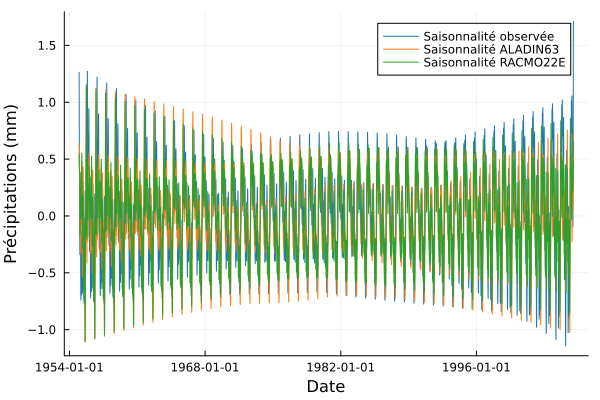

In [56]:
@df stl_df.decomposition plot(:Timestamp, :Seasonal,  label = "Saisonnalité observée",palette =:tab10, xlabel="Date", ylabel="Précipitations (mm)")
@df stl_df_drias.decomposition plot!(:Timestamp, :Seasonal, label="Saisonnalité ALADIN63",palette =:tab10)
@df stl_df_mod2.decomposition plot!(:Timestamp, :Seasonal, label="Saisonnalité RACMO22E",palette =:tab10)
#savefig("Saisonnalité_Pluies.pdf")

### BRUIT

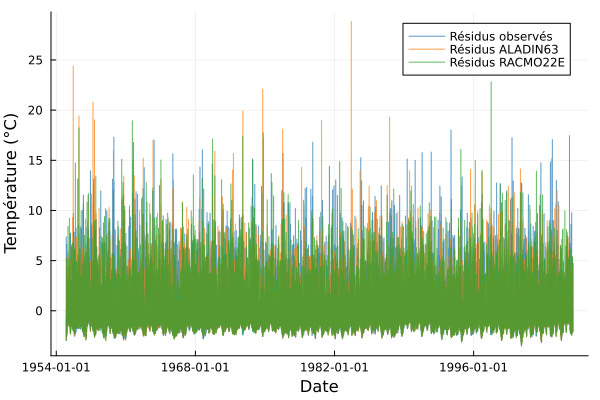

In [28]:

function retiresaisonnalite(data::Vector{T}) where T
    n = length(data)
    saisonnalite = stl_df.decomposition.Seasonal
    tendance = stl_df.decomposition.Trend
    
    for i in 1:n
        data[i] = data[i] - saisonnalite[i] - tendance[i]
    end
    
    return data
end

# Calculer la saisonnalité 
residus = retiresaisonnalite(df_daily.DAILY_MEAN)
residus_drias = retiresaisonnalite(df_daily_drias.DAILY_MEAN)
residus_mod2 = retiresaisonnalite(df_daily_mod2.DAILY_MEAN)


# Tracer la série temporelle de la saisonnalité
plot(df_daily.DATE, residus, label="Résidus observés",palette =:tab10, alpha = 0.75, xlabel="Date", ylabel="Température (°C)")
plot!(df_daily_drias.Date, residus_drias, label="Résidus ALADIN63",palette =:tab10, alpha = 0.75)
plot!(df_daily_mod2.Date, residus_mod2, label="Résidus RACMO22E",palette =:tab10, alpha = 0.75)
#savefig("Résidus_Forecast.pdf")

## Analyse des résidus

### Autocorrélogrammes de la série résiduelle

Autocorrélogramme partiel


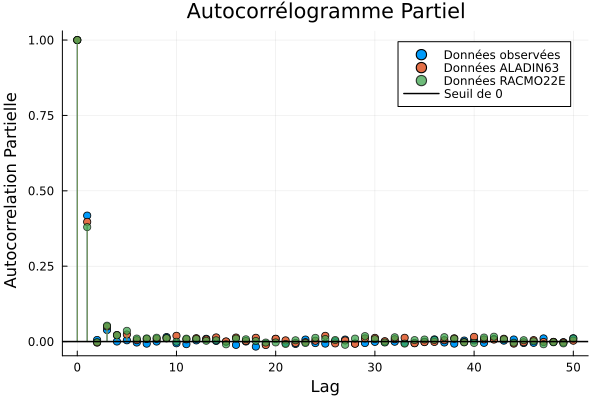

In [29]:
# Calculer l'autocorrélogramme partiel avec un nombre maximal de décalages spécifié
maxlag = 50 # Définir le nombre maximal de décalages
lags = collect(0:maxlag) # Créer une plage de décalages
pacf_values_res = StatsBase.pacf(residus, lags)
pacf_values_drias_res = StatsBase.pacf(residus_drias, lags)
pacf_values_mod2_res = StatsBase.pacf(residus_mod2, lags)

plot(0:maxlag, pacf_values_res, label = "Données observées", xlabel="Lag", ylabel=" Autocorrelation Partielle", title="Autocorrélogramme Partiel", markershape=:circle, line=:stem)
plot!(0:maxlag, pacf_values_drias_res, label = "Données ALADIN63", markershape=:circle, line=:stem)
plot!(0:maxlag, pacf_values_mod2_res, label = "Données RACMO22E", markershape=:circle, line=:stem, alpha = 0.75)
hline!([0], color=:black, linewidth=1.5, label = "Seuil de 0")
#savefig("Autocorrélogramme_Partiel.pdf")

Autocorrélogramme simple


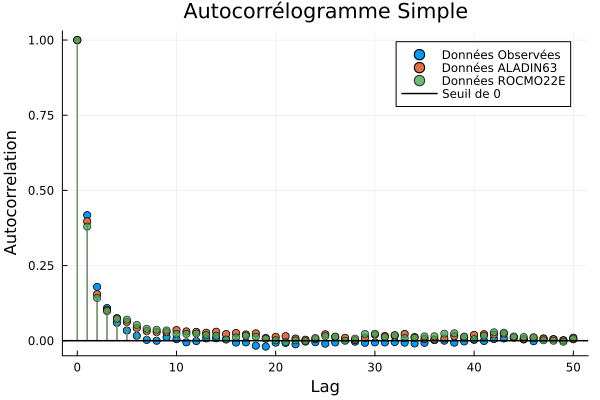

In [30]:
autocor_values = autocor(residus, lags)
autocor_values_drias = autocor(residus_drias, lags)
autocor_values_mod2 = autocor(residus_mod2, lags)

# Tracer l'autocorrélogramme empirique avec les points reliés à l'axe des abscisses et une droite d'équation nulle
plot(0:maxlag, autocor_values, label = "Données Observées", xlabel="Lag", ylabel="Autocorrelation", title="Autocorrélogramme Simple", markershape=:circle, line=:stem)
plot!(0:maxlag, autocor_values_drias, label = "Données ALADIN63", markershape=:circle, line=:stem)
plot!(0:maxlag, autocor_values_mod2, label = "Données ROCMO22E", markershape=:circle, line=:stem, alpha = 0.75)
hline!([0], color=:black, linewidth=1.5, label = "Seuil de 0")
#savefig("Autocorrélogramme_Empirique.pdf")

Estimation des coefficients de l'AR(2)

In [31]:
# Construire les matrices pour l'ajustement AR(2)
n = length(residus)
X = hcat(residus[2:end-1], residus[1:end-2])
X_drias = hcat(residus_drias[2:end-1], residus_drias[1:end-2])
X_mod2 = hcat(residus_mod2[2:end-1], residus_mod2[1:end-2])
y_target = residus[3:end]
y_target_drias = residus_drias[3:end]
y_target_mod2 = residus_mod2[3:end]

# Estimer les coefficients en utilisant les moindres carrés
coefficients = X \ y_target
coefficients_drias = X_drias \ y_target_drias
coefficients_mod2 = X_mod2 \ y_target_mod2


# Afficher les coefficients estimés
println("Coefficients estimés pour les observations : ", coefficients)
println("Coefficients estimés pour ALADIN63: ", coefficients_drias)
println("Coefficients estimés pour RACMO22E: ", coefficients_mod2)



Coefficients estimés pour les observations : [0.41563903728754287, 0.0054323813139493075]
Coefficients estimés pour ALADIN63: [0.3985123551605636, -0.003494389033251652]
Coefficients estimés pour RACMO22E: [0.3806042868340293, -0.002036342005119437]


Estimation des coefficients de l'AR(2) avec Forecast


In [32]:
# Ajuster un modèle AR(2) sur les résidus
model = ar(residus, 2)
model_drias = ar(residus_drias, 2)
model_mod2 = ar(residus_mod2, 2)

# Afficher les résultats
println(model)
println(model_drias)
println(model_mod2)


Multivariate Autoregressive Model

    ar(X, order=2, constant=true)

Residuals Summary
┌──────────┬──────────┬──────────┬───────────┬─────────────┬──────────┬─────────┬───────────┐
│ Variable │      Min │       1Q │    Median │        Mean │       3Q │     Max │ H0 Normal │
├──────────┼──────────┼──────────┼───────────┼─────────────┼──────────┼─────────┼───────────┤
│       x1 │ -8.33453 │ -1.22358 │ -0.721006 │ 6.48514e-18 │ 0.684414 │ 17.8459 │       0.0 │
└──────────┴──────────┴──────────┴───────────┴─────────────┴──────────┴─────────┴───────────┘
┌──────────┬─────────────┬──────────┬──────────┬──────────┐
│ Variable │        Mean │ Variance │ Skewness │ Kurtosis │
├──────────┼─────────────┼──────────┼──────────┼──────────┤
│       x1 │ 6.48514e-18 │  4.79068 │  1.99846 │  6.63668 │
└──────────┴─────────────┴──────────┴──────────┴──────────┘

Coefficients

Φ0
┌            ┐
│ -0.001     │
└            ┘
Φ1
┌           ┐
│ 0.416 *** │
└           ┘
Φ2
┌           ┐
│ 0.005     │
└  

## Extrêmes

In [1]:


# Fonction pour calculer la somme cumulée des pluies par année
function somme_pluie(df)
    @chain df begin
        @transform(:YEAR = year.(:DATE)) # Ajouter une colonne pour l'année
        @by(:YEAR, :YEARLY_SUM = sum(:DAILY_MEAN)) # Grouper par YEAR et prendre la somme
    end
end

function somme_pluie_drias(df)
    @chain df begin
        @transform(:YEAR = year.(:Date)) # Ajouter une colonne pour l'année
        @by(:YEAR, :YEARLY_SUM = sum(:DAILY_MEAN)) # Grouper par YEAR et prendre la somme
    end
end


df_pluies_1 = somme_pluie(df_daily)
df_pluies_2 = mean(df_pluies_1.YEARLY_SUM)
df_pluies = df_pluies_1.YEARLY_SUM .-df_pluies_2

df_pluies_drias_1 = somme_pluie_drias(df_daily_drias)
df_pluies_drias_2 = mean(df_pluies_drias_1.YEARLY_SUM)
df_pluies_drias = df_pluies_drias_1.YEARLY_SUM .-df_pluies_drias_2

df_pluies_mod2_1 = somme_pluie_drias(df_daily_mod2)
df_pluies_mod2_2 = mean(df_pluies_mod2_1.YEARLY_SUM)
df_pluies_mod2 = df_pluies_mod2_1.YEARLY_SUM .-df_pluies_mod2_2

pluies_diff_A = df_pluies_drias_1.YEARLY_SUM - df_pluies_1.YEARLY_SUM
pluies_diff_R = df_pluies_mod2_1.YEARLY_SUM - df_pluies_1.YEARLY_SUM 

bar(
    df_pluies_1.YEAR, df_pluies_1.YEARLY_SUM,
    label="Données observées",
    xlabel="Année",
    xlims = (1953,2007),
    ylabel="Somme des précipitations (mm/m2)",
    legend=:bottomright,
    alpha = 0.9)

bar!(df_pluies_drias_1.YEAR, 
df_pluies_drias_1.YEARLY_SUM, 
label="Données ALADIN63",
alpha = 0.7)

bar!(df_pluies_mod2_1.YEAR, 
df_pluies_mod2_1.YEARLY_SUM, 
label="Données RACMO22E",
alpha = 0.65)
#savefig("Pluies_obs.pdf")

bar(
    df_pluies_1.YEAR, pluies_diff_A,
    label="Avec ALADIN63",
    xlabel="Année",
    xlims = (1953,2007),
    ylabel="Différence des précipitations (mm/m2)",
    color=:darkorange,
    legend=:bottomright,
    alpha = 0.7)
    bar!(df_pluies_drias_1.YEAR, 
    pluies_diff_R, 
    color=:green,
    label="Avec RACMO22E",
    alpha = 0.5)
#savefig("Pluies_diff.pdf")

LoadError: LoadError: UndefVarError: `@chain` not defined
in expression starting at /Users/mario/Changement_climatique/data/resultats_stations_pluie.ipynb:5